# P9 - Macro Factors' Impact on Bond's Yield

## Summary: 
In this project, I explored the relationship between bond yields and various macroeconomic factors. The main focus was to understand the drivers behind bond yield changes and to attempt to predict future yields through machine learning techniques. Below is an overview of the analysis and methodologies applied:

1. Correlation Analysis: identified which macro factors—such as the federal funds rate, unemployment, CPI, and GDP growth—had the strongest relationships with different bond maturities (2-year, 5-year, 10-year). The correlation matrix provided insight into which features were most relevant to bond yield prediction and which had weaker relationships.

2. Trend Analysis: used visualizations to examine historical trends in bond yields and macro factors.

3. OLS Regression Analysis: applied ordinary least squares (OLS) regression to quantify the impact of macroeconomic variables on bond yields. Through this analysis, I found that while some factors like the federal funds rate had strong statistical significance, others such as inflation indicators showed varying levels of influence across different bond maturities and credit quality.

4. Yield Curve Analysis: analyzed how the shape of the curve changed across economic cycles from 2004 to 2024. This revealed shifts between normal, inverted, and flat yield curves, which are typically indicative of future economic conditions (e.g., recessions or periods of economic growth).

5. Machine Learning for Yield Spread Prediction: implemented an XGBoost regression model to predict bond yield spreads (such as the spread between corporate bonds and government bonds). 

Data

In [237]:
import wrds
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import plotly.graph_objects as go
import plotly.express as px
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import pickle

downloaded_data = "./downloaded_data/"

## 1. Load Data

In [16]:
# loading for various bond rates
gb_2y = pd.read_csv(downloaded_data + 'DGS2.csv', index_col = 'DATE', parse_dates = True)
gb_5y = pd.read_csv(downloaded_data + 'DGS5.csv', index_col = 'DATE', parse_dates = True)
gb_10y = pd.read_csv(downloaded_data + 'DGS10.csv', index_col = 'DATE', parse_dates = True)
cb_2y_a = pd.read_csv(downloaded_data + 'HQMCB2YR.csv', index_col = 'DATE', parse_dates = True)
cb_5y_a = pd.read_csv(downloaded_data + 'HQMCB5YR.csv', index_col = 'DATE', parse_dates = True)
cb_10y_a = pd.read_csv(downloaded_data + 'HQMCB10YR.csv', index_col = 'DATE', parse_dates = True)
cb_10y_b_to_gb_10y = pd.read_csv(downloaded_data + 'BAA10Y.csv', index_col = 'DATE', parse_dates = True)
cb_20y_b = pd.read_csv(downloaded_data + 'DBAA.csv', index_col = 'DATE', parse_dates = True)
cb_20y_a = pd.read_csv(downloaded_data + 'DAAA.csv', index_col = 'DATE', parse_dates = True)

# loading for macro factors
ff_r = pd.read_csv(downloaded_data + 'FEDFUNDS.csv', index_col = 'DATE', parse_dates = True)
unempr = pd.read_csv(downloaded_data + 'UNRATE.csv', index_col = 'DATE', parse_dates = True)
cpi = pd.read_csv(downloaded_data + 'CPI.csv')
pce = pd.read_csv(downloaded_data + 'PCEPILFE.csv', index_col = 'DATE', parse_dates = True)
ipi = pd.read_csv(downloaded_data + 'INDPRO.csv', index_col = 'DATE', parse_dates = True)
vix = conn.raw_sql(f"""
                    SELECT date, vix FROM cboe.cboe""",
                    date_cols = ['date']
                    )
fd_gdp = pd.read_csv(downloaded_data + 'GFDEGDQ188S.csv', index_col = 'DATE', parse_dates = True)
as_debt = pd.read_csv(downloaded_data + 'ASTDSL.csv', index_col = 'DATE', parse_dates = True)
ncb_debt = pd.read_csv(downloaded_data + 'BCNSDODNS.csv', index_col = 'DATE', parse_dates = True)
ncb_debt_equity = pd.read_csv(downloaded_data + 'NCBCMDPMVCE.csv', index_col = 'DATE', parse_dates = True)
hnp_nw_as_dpi = pd.read_csv(downloaded_data + 'HNONWPDPI.csv', index_col = 'DATE', parse_dates = True)
hnp_cc = pd.read_csv(downloaded_data + 'CCLBSHNO.csv', index_col = 'DATE', parse_dates = True)

## 2. Data Process

In [17]:
# calculate yoy % 
pce['PCE_yoy'] = pce['PCEPILFE'].pct_change(12) * 100
ipi['IPI_yoy'] = ipi['INDPRO'].pct_change(12) * 100

# format cpi data
cpi.Label = pd.to_datetime(cpi.Label)
cpi = cpi.set_index('Label')
vix = vix[~vix.duplicated(subset = 'date', keep = 'first')]
vix = vix.set_index('date')

# update daily data to monthly and convert the datatype to float.
daily_data_list = [gb_2y, gb_5y, gb_10y, cb_10y_b_to_gb_10y, cb_20y_b, cb_20y_a, vix]

monthly_data_list = []
for i in range(len(daily_data_list)): 
    column = daily_data_list[i].columns[0]
    daily_data_list[i][column] = pd.to_numeric(daily_data_list[i][column], errors='coerce').astype('float32')
    updated_dates = pd.date_range(start = '2004-1-1', end = '2024-9-1', freq =  "D" )
    df_daily = pd.DataFrame(index = updated_dates)
    df_daily[column] = daily_data_list[i][column]
    df_daily[column] = df_daily[column].bfill()
    df_monthly = df_daily.resample('MS').first()
    monthly_data_list.append(df_monthly)

C:\Users\m1852\AppData\Local\Temp\ipykernel_12156\1575463203.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cpi.Label = pd.to_datetime(cpi.Label)


In [ ]:
quarterly_data = [fd_gdp, as_debt, ncb_debt, ncb_debt_equity, hnp_nw_as_dpi, hnp_cc]

for i in range(len(quarterly_data)): 
    column = quarterly_data[i].columns[0]
    monthly_data = quarterly_data[i].resample('MS').interpolate(method='linear')
    monthly_data_list.append(monthly_data)

In [30]:
monthly_data_list[7]['FD_GDP'] = np.log(monthly_data_list[7]['GFDEGDQ188S']) 
monthly_data_list[7].drop(columns = ['GFDEGDQ188S'], inplace = True)
monthly_data_list[8]['AS_DEBT_yoy'] = monthly_data_list[8]['ASTDSL'].pct_change(12) * 100
monthly_data_list[8].drop(columns = ['ASTDSL'], inplace = True)
monthly_data_list[9]['NCB_DEBT_yoy'] = monthly_data_list[9]['BCNSDODNS'].pct_change(12) * 100
monthly_data_list[9].drop(columns = ['BCNSDODNS'], inplace = True)
monthly_data_list[11]['HNP_NW_DPI_log'] = np.log(monthly_data_list[11]['HNONWPDPI']) 
monthly_data_list[11].drop(columns = ['HNONWPDPI'], inplace = True)
monthly_data_list[12]['HNP_CC_yoy'] = monthly_data_list[12]['CCLBSHNO'].pct_change(12) * 100
monthly_data_list[12].drop(columns = ['CCLBSHNO'], inplace = True)

In [33]:
# create aggregate_table for all data
aggregate_table = pd.DataFrame()
aggregate_table['2Y_GB'] = monthly_data_list[0]
aggregate_table['5Y_GB'] = monthly_data_list[1]
aggregate_table['10Y_GB'] = monthly_data_list[2]
aggregate_table['2Y_HQ_CB'] = cb_2y_a
aggregate_table['5Y_HQ_CB'] = cb_5y_a
aggregate_table['10Y_HQ_CB'] = cb_10y_a
aggregate_table['10Y_LQ_CB'] = monthly_data_list[2]['DGS10'] + monthly_data_list[3]['BAA10Y']
aggregate_table['10Y_CCS'] = aggregate_table['10Y_LQ_CB'] - aggregate_table['10Y_HQ_CB'] # note high quality includes AAA, AA or A Moody-rated bonds, low quality includes Baa 
aggregate_table['20Y_CCS'] = monthly_data_list[4]['DBAA'] - monthly_data_list[5]['DAAA'] # note it's the credit spread between Moody's Baa and Moody's Aaa
aggregate_table['FF_r'] = ff_r
aggregate_table['Unemp'] = unempr
aggregate_table['CPI_yoy'] = cpi['12-Month % Change']
aggregate_table['PCE_yoy'] = pce['PCE_yoy']
aggregate_table['IPI_yoy'] = ipi['IPI_yoy']
aggregate_table['vix'] = monthly_data_list[6]['vix']
aggregate_table['fd_gdp'] = monthly_data_list[7]['FD_GDP']
aggregate_table['AS_DEBT_yoy'] = monthly_data_list[8]['AS_DEBT_yoy']
aggregate_table['NCB_DEBT_yoy'] = monthly_data_list[9]['NCB_DEBT_yoy']
aggregate_table['NCE_DEBT_EQUITY'] = monthly_data_list[10]['NCBCMDPMVCE']
aggregate_table['HNP_NW_DPI'] = monthly_data_list[11]['HNP_NW_DPI_log']
aggregate_table['HNP_CC_yoy'] = monthly_data_list[12]['HNP_CC_yoy']

In [34]:
# get rid of the last two months due to limited data availability
aggregate = aggregate_table[:-2].copy()
aggregate.head()

,2Y_GB,5Y_GB,10Y_GB,2Y_HQ_CB,5Y_HQ_CB,10Y_HQ_CB,10Y_LQ_CB,10Y_CCS,20Y_CCS,FF_r,...,CPI_yoy,PCE_yoy,IPI_yoy,vix,fd_gdp,AS_DEBT_yoy,NCB_DEBT_yoy,NCE_DEBT_EQUITY,HNP_NW_DPI,HNP_CC_yoy
2004-01-01,1.94,3.36,4.38,2.14,3.84,5.18,6.70,1.52,0.97,1.00,...,1.1,1.828988,1.305618,18.219999,4.091124,13.303677,2.337452,35.921190,6.415476,5.396800
2004-02-01,1.83,3.18,4.18,2.12,3.81,5.13,6.35,1.22,0.80,1.01,...,1.2,1.853270,1.807113,17.110001,4.092504,13.035176,2.378177,35.715801,6.415394,5.121633
2004-03-01,1.67,2.98,4.00,1.92,3.52,4.87,6.20,1.33,0.77,1.00,...,1.6,1.860489,1.688121,14.440000,4.093882,12.770251,2.418885,35.510411,6.415312,4.849458
2004-04-01,1.65,2.87,3.91,2.43,4.12,5.40,6.18,0.78,0.78,1.00,...,1.8,2.012449,2.725390,16.650000,4.095259,12.508833,2.459575,35.305021,6.415231,4.580228
2004-05-01,2.34,3.63,4.53,2.96,4.65,5.84,6.58,0.74,0.71,1.00,...,1.7,2.005745,3.522677,16.620001,4.094768,12.514968,2.657301,35.640568,6.419256,4.758193


In [35]:
aggregate.describe()

,2Y_GB,5Y_GB,10Y_GB,2Y_HQ_CB,5Y_HQ_CB,10Y_HQ_CB,10Y_LQ_CB,10Y_CCS,20Y_CCS,FF_r,...,CPI_yoy,PCE_yoy,IPI_yoy,vix,fd_gdp,AS_DEBT_yoy,NCB_DEBT_yoy,NCE_DEBT_EQUITY,HNP_NW_DPI,HNP_CC_yoy
count,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,...,247.000000,247.000000,247.000000,247.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000
mean,1.872186,2.367895,2.935668,2.706802,3.455466,4.485344,5.399717,0.914372,1.030283,1.605101,...,2.406073,2.117538,0.693916,19.082510,4.518019,5.756616,5.126841,31.496973,6.487247,4.509053
std,1.622010,1.317186,1.140295,1.747007,1.514385,1.266567,1.146906,0.353290,0.429188,1.862614,...,1.230475,1.097680,4.639910,8.519051,0.241311,2.945700,3.791417,7.268764,0.105704,2.802897
min,0.110000,0.220000,0.560000,0.350000,0.790000,2.010000,3.120000,-0.980000,0.540000,0.050000,...,0.600000,0.625583,-17.202282,9.450000,4.091124,2.453762,-5.822082,19.438370,6.300103,-3.357757
25%,0.500000,1.375000,2.035000,1.295000,2.280000,3.530000,4.655000,0.685000,0.790000,0.120000,...,1.700000,1.500415,-0.820759,13.465000,4.355393,3.482884,3.148272,27.056777,6.415455,3.785560
50%,1.240000,2.010000,2.770000,1.990000,3.180000,4.350000,5.370000,0.950000,0.930000,0.650000,...,2.100000,1.782408,2.049416,16.440001,4.608048,4.724502,5.811156,30.720989,6.496473,5.270337
75%,2.860000,3.460000,3.930000,4.500000,4.755000,5.400000,6.210000,1.140000,1.110000,2.415000,...,2.350000,2.205911,3.126135,22.485000,4.650011,7.125147,7.418281,34.599063,6.544335,6.218547
max,5.170000,5.110000,5.150000,7.350000,8.180000,8.850000,9.490000,1.820000,3.490000,5.330000,...,6.600000,5.649107,16.119871,68.510002,4.888956,14.021557,13.691778,59.603629,6.728218,9.833009


## 3. Correlation Analysis

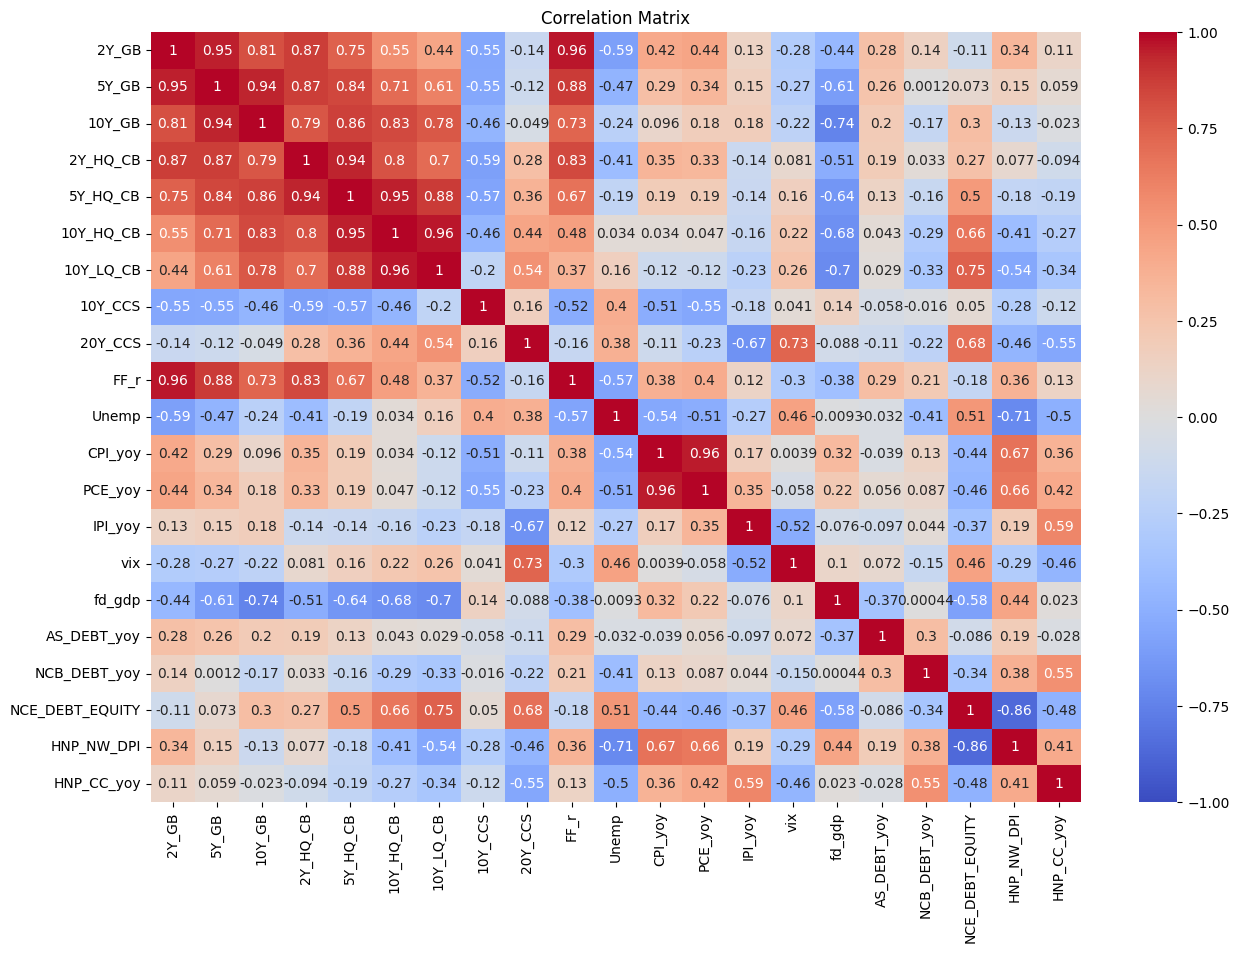

In [37]:
# correlation analysis
corr_matrix = aggregate.corr()

plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()


### Insights from the correlation matrix: 

- Government bond yields at different maturities tend to move in tandem.
- Unemployment rate has generally a negatively correlaiton with various government bond yield. Higher unemployment rates tend to coincide with lower bond yields, which is consistent with economic downturns leading to lower interest rates.
- Federal debt to GDP shows a strong inverse correlation with all bond yields, both government and corporate bonds, indicating that investor's demand for safer assets, driving down the yield of government bonds. 
- Volatility Index(VIX) has moderate positive correlations with 10Y_CS (credit spread) at 0.73, reflecting that higher market volatility tends to be associated with wider credit spreads.
- Corporate DEBT-to-EQUITY ratio also shows moderate correlations with both corporate bond yields (10Y_HQ_CB and 10Y_LQ_CB), more significant impact on lower quality bonds,  indicating the influence of corporate leverage on bond yields.

## 4. Trend Analysis

In [38]:
# Define the function to draw parameter trend

def plot_bond_vs_macro(bond_column):
    # Create a figure with 3 subplots in one row
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # Plot bond yield and FF_r on ax1
    ax1.plot(aggregate.index, aggregate[bond_column], color='blue', label=bond_column)
    ax1.set_ylabel(f'{bond_column} (%)', color='blue')
    ax1.set_title(f'{bond_column} vs FF_r')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax1_twin = ax1.twinx()  # Create a secondary y-axis
    ax1_twin.plot(aggregate.index, aggregate['FF_r'], color='red', label='FF_r')
    ax1_twin.set_ylabel('FF_r (%)', color='red')
    ax1_twin.tick_params(axis='y', labelcolor='red')

    # Plot bond yield and CPI_yoy on ax2
    ax2.plot(aggregate.index, aggregate[bond_column], color='blue', label=bond_column)
    ax2.set_ylabel(f'{bond_column} (%)', color='blue')
    ax2.set_title(f'{bond_column} vs CPI_yoy')
    ax2.tick_params(axis='y', labelcolor='blue')

    ax2_twin = ax2.twinx()  # Create a secondary y-axis
    ax2_twin.plot(aggregate.index, aggregate['CPI_yoy'], color='green', label='CPI YoY')
    ax2_twin.set_ylabel('CPI YoY (%)', color='green')
    ax2_twin.tick_params(axis='y', labelcolor='green')

    # Plot bond yield and VIX on ax3
    ax3.plot(aggregate.index, aggregate[bond_column], color='blue', label=bond_column)
    ax3.set_ylabel(f'{bond_column} (%)', color='blue')
    ax3.set_title(f'{bond_column} vs VIX')
    ax3.tick_params(axis='y', labelcolor='blue')

    ax3_twin = ax3.twinx()  # Create a secondary y-axis
    ax3_twin.plot(aggregate.index, aggregate['vix'], color='purple', label='VIX')
    ax3_twin.set_ylabel('VIX', color='purple')
    ax3_twin.tick_params(axis='y', labelcolor='purple')

    # Adjust layout to avoid overlapping
    plt.tight_layout()

    # Show the plot
    plt.show()

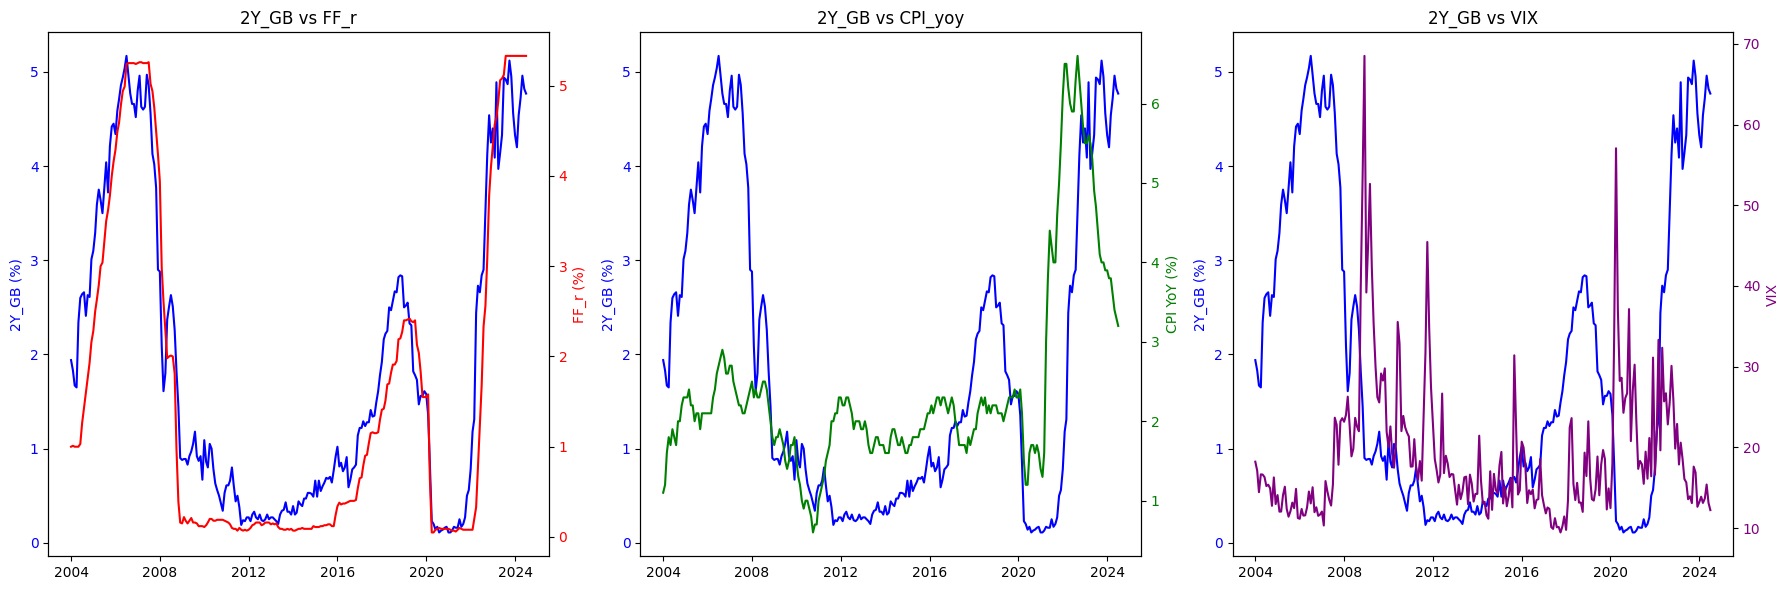

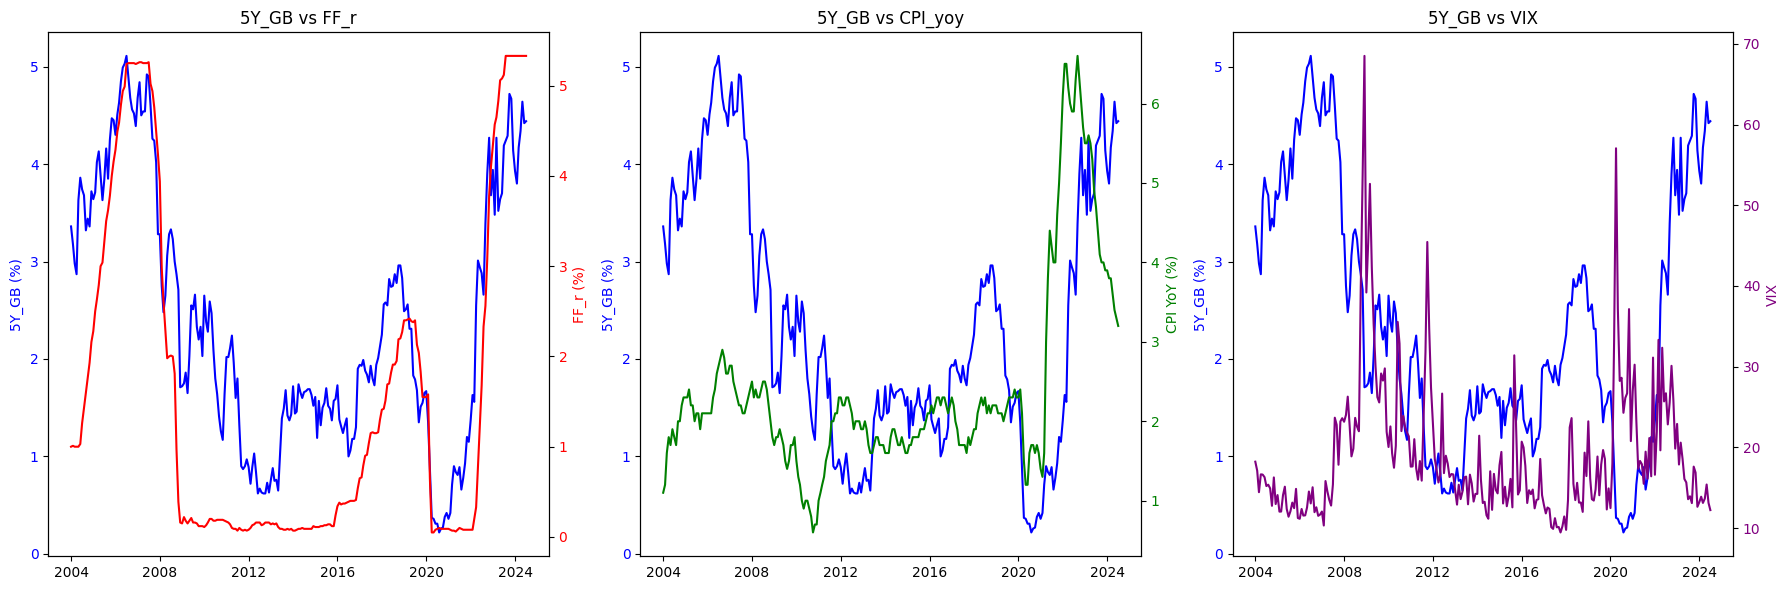

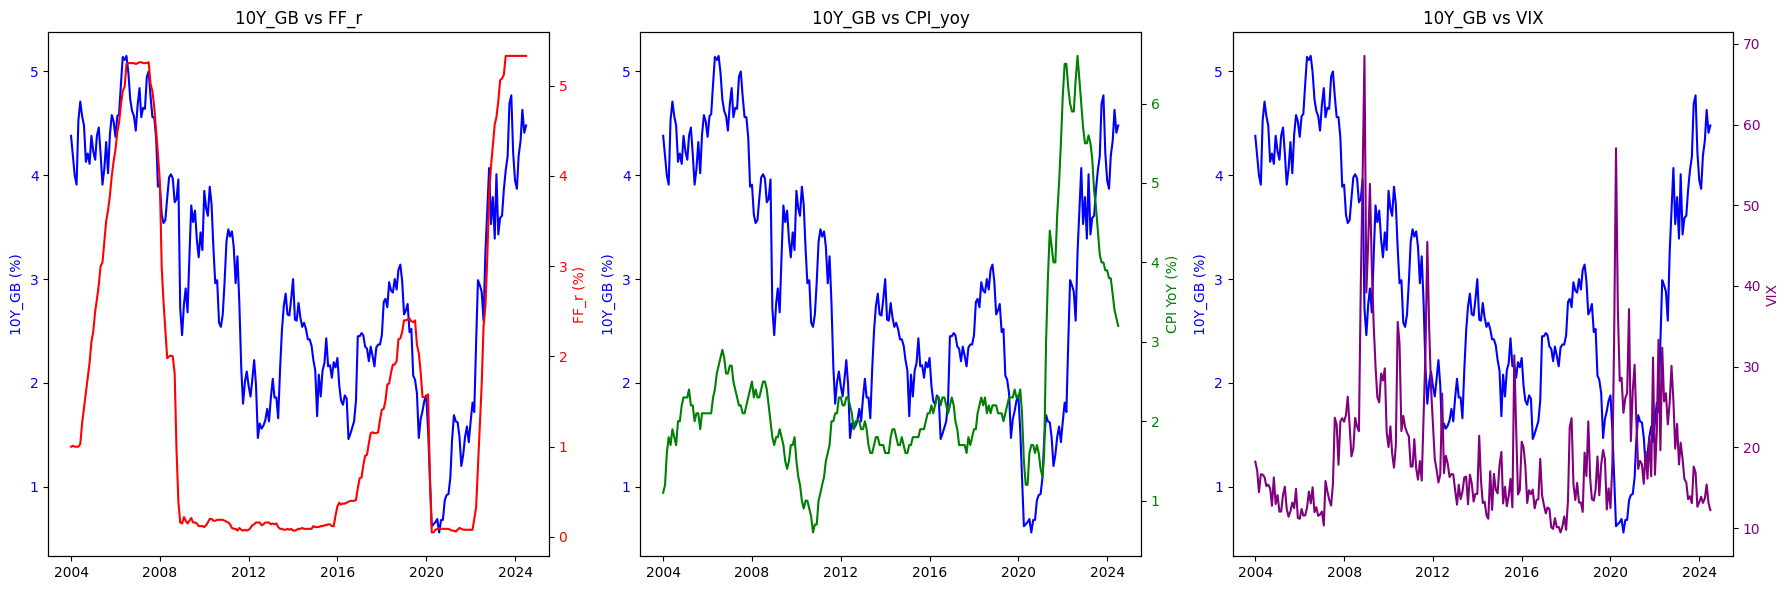

In [107]:
# plot for 2Y_GB
plot_bond_vs_macro('2Y_GB')

# plot for 5Y_GB
plot_bond_vs_macro('5Y_GB')

# plot for 10Y_GB
plot_bond_vs_macro('10Y_GB')

## 5. Running OLS analysis

In [116]:
import statsmodels.api as sm
# Define the function to run OLS regression 
def run_ols(dependent_var):
    # Define independent variables
    X = aggregate[['FF_r', 'CPI_yoy', 'PCE_yoy', 'Unemp', 'IPI_yoy', 'vix']]
    
    # Add constant for intercept
    X = sm.add_constant(X)
    
    # Define dependent variable (passed as argument)
    y = aggregate[dependent_var]
    
    # Fit the regression model
    model = sm.OLS(y, X).fit()
    
    # Return the model summary
    return model.summary()

In [122]:
# Calculate credit spread between 10Y_HQ_CB and 10Y_GB
aggregate['10Y_CS'] = aggregate['10Y_HQ_CB'] - aggregate['10Y_GB']

# Running OLS regression analysis
print(run_ols('10Y_GB'))
print(run_ols('10Y_HQ_CB'))
print(run_ols('10Y_LQ_CB'))
print(run_ols('10Y_CS'))

                            OLS Regression Results                            
Dep. Variable:                 10Y_GB   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     67.86
Date:                Sun, 13 Oct 2024   Prob (F-statistic):           5.92e-49
Time:                        17:53:02   Log-Likelihood:                -259.89
No. Observations:                 247   AIC:                             533.8
Df Residuals:                     240   BIC:                             558.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7546      0.268      6.557      0.0

## 6. Drawing yield curve

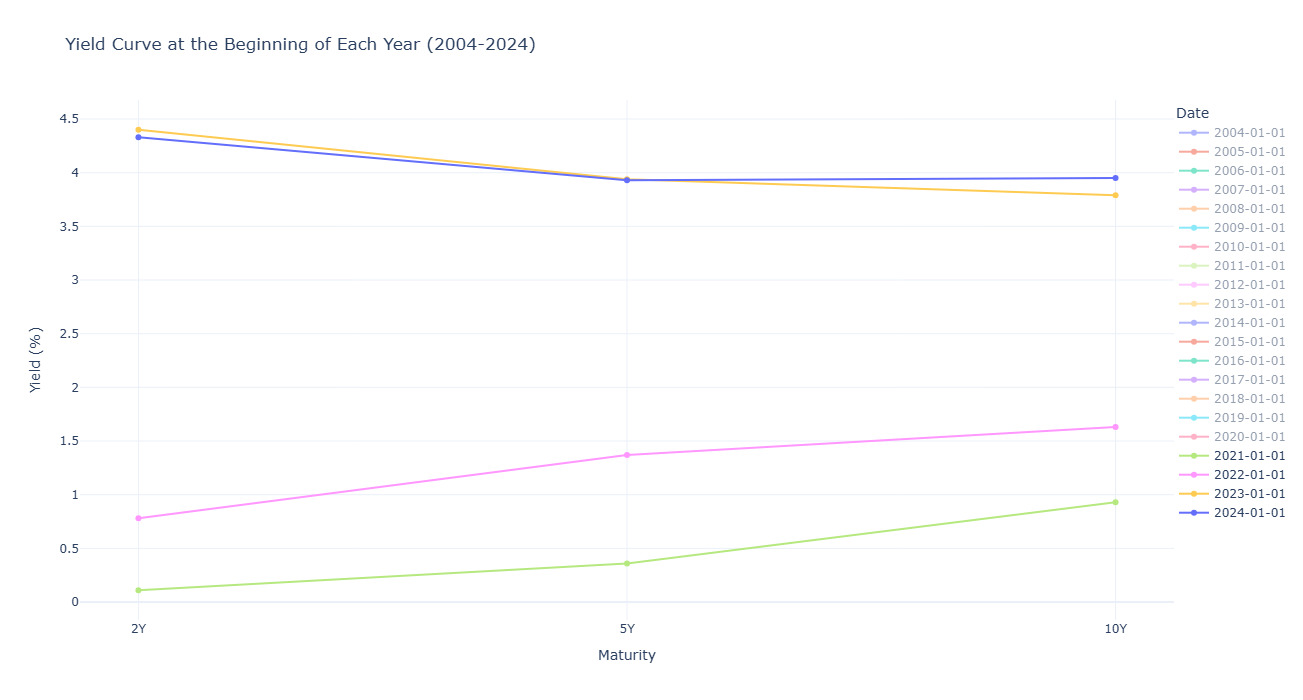

In [77]:
# Generate the list of dates for January 1st of each year from 2004 to 2024
years = list(range(2004, 2025))
dates_to_plot = [f'{year}-01-01' for year in years]

maturities = ['2Y', '5Y', '10Y']

fig = go.Figure()

# Loop through each year and add a line for the yield curve
for date in dates_to_plot:
    if date in aggregate.index:
        bond_yields = [
            aggregate.loc[date, '2Y_GB'],
            aggregate.loc[date, '5Y_GB'],
            aggregate.loc[date, '10Y_GB']
        ]
        
        # Add the yield curve as a line in the figure
        fig.add_trace(go.Scatter(x=maturities, y=bond_yields, mode='lines+markers', name=date))

fig.update_layout(
    title="Yield Curve at the Beginning of Each Year (2004-2024)",
    xaxis_title="Maturity",
    yaxis_title="Yield (%)",
    legend_title="Date",
    hovermode="x unified",  
    template="plotly_white",  
    legend=dict(x=1, y=1, traceorder='normal', bgcolor='rgba(0,0,0,0)'),
    width=900,  
    height=700,  
)

fig.show()

## 8. Predict Crdit Spread Using Machine learning

In [55]:
# Add additional term features: 
# Calculate the 5-year to 2-year spread 
aggregate['5Y_2Y_TS'] = aggregate['5Y_GB'] - aggregate['2Y_GB']

# Calculate the 10-year to 2-year spread
aggregate['10Y_2Y_TS'] = aggregate['10Y_GB'] - aggregate['2Y_GB']

# Calculate the 10-year corporate to government credit spread
aggregate['10Y_CS'] = aggregate['10Y_HQ_CB'] - aggregate['10Y_GB']

In [56]:
aggregate.head()

,2Y_GB,5Y_GB,10Y_GB,2Y_HQ_CB,5Y_HQ_CB,10Y_HQ_CB,10Y_LQ_CB,10Y_CCS,20Y_CCS,FF_r,...,vix,fd_gdp,AS_DEBT_yoy,NCB_DEBT_yoy,NCE_DEBT_EQUITY,HNP_NW_DPI,HNP_CC_yoy,5Y_2Y_TS,10Y_2Y_TS,10Y_CS
2004-01-01,1.94,3.36,4.38,2.14,3.84,5.18,6.70,1.52,0.97,1.00,...,18.219999,4.091124,13.303677,2.337452,35.921190,6.415476,5.396800,1.42,2.44,0.80
2004-02-01,1.83,3.18,4.18,2.12,3.81,5.13,6.35,1.22,0.80,1.01,...,17.110001,4.092504,13.035176,2.378177,35.715801,6.415394,5.121633,1.35,2.35,0.95
2004-03-01,1.67,2.98,4.00,1.92,3.52,4.87,6.20,1.33,0.77,1.00,...,14.440000,4.093882,12.770251,2.418885,35.510411,6.415312,4.849458,1.31,2.33,0.87
2004-04-01,1.65,2.87,3.91,2.43,4.12,5.40,6.18,0.78,0.78,1.00,...,16.650000,4.095259,12.508833,2.459575,35.305021,6.415231,4.580228,1.22,2.26,1.49
2004-05-01,2.34,3.63,4.53,2.96,4.65,5.84,6.58,0.74,0.71,1.00,...,16.620001,4.094768,12.514968,2.657301,35.640568,6.419256,4.758193,1.29,2.19,1.31


In [157]:
# Adding time lagging features. 
aggregate['NCB_DEBT_yoy_lag1'] = aggregate['NCB_DEBT_yoy'].shift(1) 
aggregate['AS_DEBT_yoy_lag1'] = aggregate['AS_DEBT_yoy'].shift(1) 
aggregate['NCB_DEBT_yoy_lag3'] = aggregate['NCB_DEBT_yoy'].shift(3) 
aggregate['AS_DEBT_yoy_lag3'] = aggregate['AS_DEBT_yoy'].shift(3) 

In [158]:
aggregate_updated = aggregate.iloc[3:-3]

In [159]:
aggregate_updated.columns

Index(['2Y_GB', '5Y_GB', '10Y_GB', '2Y_HQ_CB', '5Y_HQ_CB', '10Y_HQ_CB',
       '10Y_LQ_CB', '10Y_CCS', '20Y_CCS', 'FF_r', 'Unemp', 'CPI_yoy',
       'PCE_yoy', 'IPI_yoy', 'vix', 'fd_gdp', 'AS_DEBT_yoy', 'NCB_DEBT_yoy',
       'NCE_DEBT_EQUITY', 'HNP_NW_DPI', 'HNP_CC_yoy', '5Y_2Y_TS', '10Y_2Y_TS',
       '10Y_CS', 'NCB_DEBT_yoy_lag1', 'AS_DEBT_yoy_lag1', 'NCB_DEBT_yoy_lag3',
       'AS_DEBT_yoy_lag3'],
      dtype='object')

### XGBoost Model for 10Y Corporate Credit Spread

In [261]:
# Step 1: Define independent (X) and dependent (y) variables
X = aggregate_updated[['FF_r', 'Unemp','PCE_yoy', 'IPI_yoy', 'vix', 'fd_gdp', 'AS_DEBT_yoy',
                       'NCB_DEBT_yoy','NCE_DEBT_EQUITY', 'HNP_CC_yoy', '5Y_2Y_TS', '10Y_2Y_TS', 'AS_DEBT_yoy_lag1']].values  # Features
y = aggregate_updated['10Y_CCS'].values  # Target variable (bond yield)

# Step 2: Split the data
train_size = int(0.8 * len(X))  # 80% for training

X_train, X_test = X[:train_size], X[train_size:]  # First 80% is training, last 20% is test
y_train, y_test = y[:train_size], y[train_size:]


# Step 3: Time Series Split on training data only (for cross-validation)
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Step 4: Set parameters and train the model
params = {
    'objective': 'reg:squarederror',  
    'max_depth': 5,
    'learning_rate': 0.1,
    'subsample': 0.8,  
    'colsample_bytree': 0.8,  
    'min_child_weight': 5,
    'reg_alpha': 0.1,
    'reg_lambda': 1
}

# Step 5: Cross-validation
train_rmse_list = []
test_rmse_list = []

for train_index, val_index in tscv.split(X_train):
    X_t_train, X_val = X_train[train_index], X_train[val_index]
    y_t_train, y_val = y_train[train_index], y_train[val_index]

    # Convert to DMatrix for XGBoost
    train_matrix = xgb.DMatrix(X_t_train, label=y_t_train)
    val_matrix = xgb.DMatrix(X_val, label=y_val)
    
    # Train XGBoost model
    model = xgb.train(params, train_matrix, num_boost_round=100, evals=[(val_matrix, 'val')], 
                      early_stopping_rounds=10, verbose_eval=False)
    
    # Predictions on validation set
    y_val_pred = model.predict(val_matrix)
    
    # Calculate RMSE
    train_rmse = np.sqrt(mean_squared_error(y_t_train, model.predict(train_matrix)))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    
    train_rmse_list.append(train_rmse)
    test_rmse_list.append(val_rmse)

    # Display results for each fold
    print(f"Train RMSE: {train_rmse:.4f}, Validation RMSE: {val_rmse:.4f}")

# Display final average RMSE for cross-validation
print(f"Average Train RMSE: {np.mean(train_rmse_list):.4f}")
print(f"Average Validation RMSE: {np.mean(test_rmse_list):.4f}")

Train RMSE: 0.0654, Validation RMSE: 0.5008
Train RMSE: 0.1979, Validation RMSE: 0.1793
Train RMSE: 0.0913, Validation RMSE: 0.2244
Train RMSE: 0.1207, Validation RMSE: 0.2768
Train RMSE: 0.1941, Validation RMSE: 0.2572
Average Train RMSE: 0.1339
Average Validation RMSE: 0.2877


Training RMSE: 0.11500527529192564


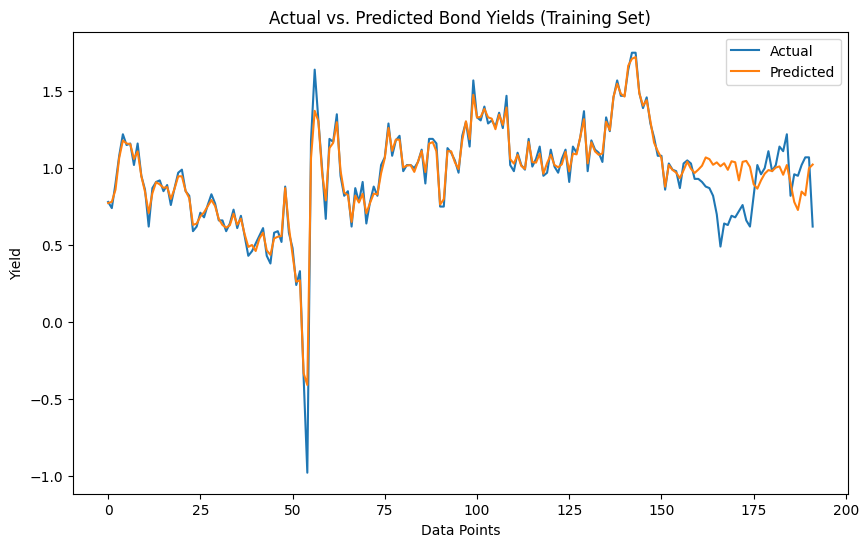

In [262]:
# Train the model on the full training data
final_model_10y_gb = xgb.train(
    params=params,  # Use the same parameters
    dtrain=train_matrix,  # Use the full training data
    num_boost_round=100  # Set this to the number of iterations you've chosen
)

train_matrix = xgb.DMatrix(X_train, label=y_train)
test_matrix = xgb.DMatrix(X_test, label=y_test)

# Make predictions on the training data
y_train_pred = final_model_10y_gb.predict(train_matrix)

# Calculate RMSE on the training set
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f"Training RMSE: {rmse_train}")

plt.figure(figsize=(10, 6))
plt.plot(y_train, label='Actual')
plt.plot(y_train_pred, label='Predicted')
plt.title('Actual vs. Predicted Bond Yields (Training Set)')
plt.xlabel('Data Points')
plt.ylabel('Yield')
plt.legend()
plt.show()

In [264]:
# Get feature importance scores
importance = final_model_10y_gb.get_score(importance_type='weight')

# Print the feature importance
print(importance)

{'f0': 93.0, 'f1': 44.0, 'f2': 92.0, 'f3': 103.0, 'f4': 111.0, 'f5': 61.0, 'f6': 88.0, 'f7': 90.0, 'f8': 93.0, 'f9': 93.0, 'f10': 77.0, 'f11': 72.0, 'f12': 61.0}


Test RMSE: 0.3902787491559448


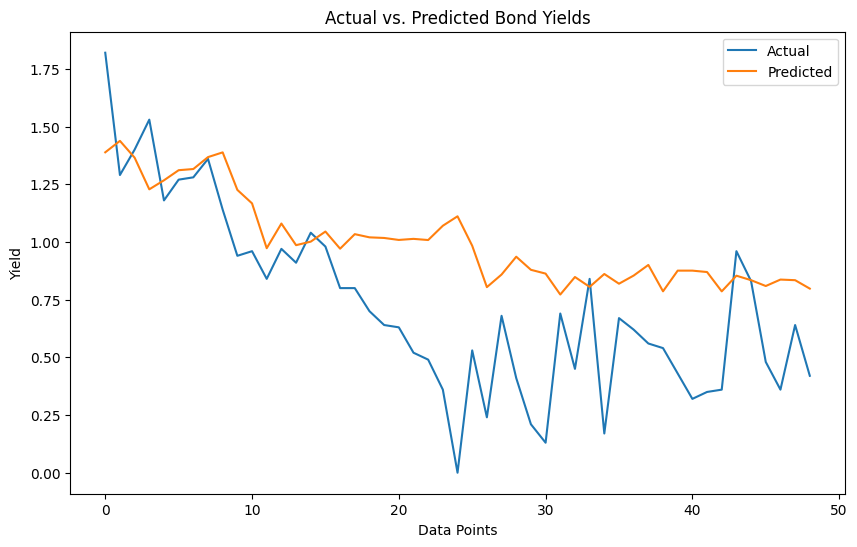

In [265]:
# Make predictions on the test data
y_pred = final_model_10y_gb.predict(test_matrix)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse}")

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs. Predicted Bond Yields')
plt.xlabel('Data Points')
plt.ylabel('Yield')
plt.legend()
plt.show()

### Key takeaways from the Yield Spread Prediction using XGBoost Machine Learning:

1. Understanding Feature Selection: Initially, the challenge revolved around identifying the right set of features to predict bond yields effectively. Early in the project, I used commonly available macroeconomic data, such as interest rates, inflation indicators (CPI and PCE), IPI and market volatility (VIX). However, through trial and error, I realized that these features alone might not fully capture the complex dynamics driving bond yields. The potential absence of liquidity data, risk premiums, or other market-specific factors likely limited the model’s ability to accurately predict yields. This emphasized the importance of exploring and incorporating more granular or niche data sources in future projects.

2. Dealing with Non-Stationary Time-Series Data: One of the significant technical hurdles was the non-stationary nature of the time-series data, where economic conditions shift rapidly, making it difficult for models trained on historical data to generalize well to future periods. This realization led to deeper research into time-series-specific machine learning models, as well as alternative approaches like regime-switching models that might better account for these economic shifts.

3. Lagging Features and Market Sensitivity: A breakthrough in understanding came when I experimented with lagging variables. Although lagged features help capture past dependencies, they also introduce potential multicollinearity, which can destabilize the model. Additionally, the model struggled to capture rapid market shifts, resulting in smoother predictions that didn't align well with the actual, more volatile data. This highlighted the need to incorporate features that are sensitive to short-term market movements, such as liquidity metrics or intraday data.

4. Model Performance and Cross-Validation: During cross-validation, I observed that training RMSE remained much lower than validation RMSE, suggesting overfitting despite attempts to tune parameters and introduce regularization. This learning led me to explore feature engineering further, recognizing that the features themselves might not be dynamic enough to explain yield variations, especially for long-term bonds. Incorporating additional features, such as term spreads and credit spreads, improved the model's performance slightly but still posed challenges in generalizing across different time periods.

5. Reflection on Machine Learning's Applicability: This project revealed some of the limitations of using traditional machine learning models like XGBoost in financial markets, particularly when applied to long-term, non-stationary economic data. While machine learning excels in pattern recognition, bond yields are influenced by a broad set of economic, political, and market-specific factors that might be better handled with models tailored for time-series data or econometrics. This realization sparked an interest in exploring hybrid models that combine machine learning with more traditional econometric techniques.

6. Next Steps and Improvements: Based on these learnings, the next steps would involve incorporating regime analysis, adding more short-term market-sensitive features, and expanding the dataset with more historical information. I would also explore other model architectures, such as recurrent neural networks (RNNs) or ARIMA models, which may be better suited to time-series prediction in the context of bond yields.
